In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams 
from nltk.tag import pos_tag


import gensim
from collections import Counter, defaultdict
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from typing import List, Dict, Set, Tuple, Callable, Iterable
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import os


## Introduction 

### The Myers-Briggs Type Indicator (MBTI)

Myers-Briggs Type Indicator (MBTI) is a self-report questionnaire that permits to classify people into 16 psychological types. The types are derived from Jung personality theory, and represent some sort of archetypes.

Types are defined by four dichotomies (pairs of opposite traits):

- **E**xtraversion (E) vs **I**ntroversion (I) $\leftarrow$ 
  - are you more internally or externally focused? 
  - Do you gain energy from being around people or from being alone?
- **S**ensing (S) vs i**N**tuition (N) $\leftarrow$ 
  - how do you gather information? 
  - Are you more practical and concrete or more abstract and theoretical?
- **T**hinking (T) vs **F**eeling (F) $\leftarrow$ 
  - how do you make decisions? 
  - Are you more rational (detached, reasonable, logical) or more emotional (empathetic, compassionate, sensitive, involved from inside)?
- **J**udging (J) vs **P**erceiving (P) $\leftarrow$ (a bit more tricky) 
  - it is a sort of lifestyle preference. 
  - Do you prefer to show externally your main perceiving function (sensing or intuition) or your main judging function (thinking or feeling)? 

$\Rightarrow$ combining those four dichotomies, you obtain 16 types, each one with a specific combination of traits. Each type is identified by four letters. Some examples:

> *"ENFP"* $\leftarrow$ Extraverted, iNtuitive, Feeler, who prefers do display his perceiving function (iNtuition).
> 
> *"ISTJ"* $\leftarrow$ Introverted, Sensor, Thinker, who prefers to display his judging function (Thinking).

Moreover, each type has been labelled with an "archetipal" name. For example, the ENFP type is called "The Campaigner", and the ISTJ type is called "The Logistician", etc.


### Further ideas and criticisms 

- there is a whole theory about the cognitive functions, differences between original Jung theory and MBTI, correlation with other indicators, etc.
- there is also a lot of criticism on validity and reliability of the test...
  - not all the theory is not based on scientific evidence
  - there is few evidence of the existence of some traits and some other traits seems not to be so dichotomous
  - "non predictive" nature of the test
  - business and companies born around the test
  - etc.

Some sources:

- Wikipedia: https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator
- The 16 personalities descriptions and the main test website: https://www.16personalities.com/personality-types 

### What we do in this project

In this project we take the descriptions of the 16 types and we try to extract some information from them, using various NLP techniques.

## The dataset

- Source: https://www.kaggle.com/datasets/yamaerenay/mbtitypes-full?select=types.csv 
  - (it contains the descriptions of the main website, grouped in a single CSV table)
- For each type, we have
  - the four letters dichotomy
  - the archetipal name (nickname)
  - various descriptions of different aspects of the type (e.g. "strengths", "weaknesses", "romantic relationships", etc.)

### Data gathering

You can download the CSV dataset from the [link above](https://www.kaggle.com/datasets/yamaerenay/mbtitypes-full?select=types.csv). To begin the analysis, extract eventual ZIPs and put the `types.csv` file it in the `./data/` folder.

In [2]:
types = pd.read_csv('data/types.csv')
types.set_index('Type', inplace=True)

In [3]:
types.head(3)

,Introduction,Strengths and Weaknesses,Romantic Relationships,Friendships,Parenthood,Career Paths,Workplace Habits,Conclusion,Celebrities,Description,Nickname,Definition,E,I,N,S,T,F,J,P
Type,,,,,,,,,,,,,,,,,,,,
INTJ,Introduction\n\nWHO IS AN ARCHITECT (INTJ)?\n\...,Strengths & Weaknesses\nArchitect (INTJ) Stren...,Romantic Relationships\n\n“Of all forms of cau...,Friendships\n\n“A friend to all is a friend to...,Parenthood\n\n“Children must be taught how to ...,Career Paths\n\n“One never notices what has be...,Workplace Habits\n\nWhat Architects (INTJs) wa...,Conclusion\n\n“No escape from patterns and sys...,"['Friedrich Nietzsche', 'Michelle Obama', 'Elo...","Imaginative and strategic thinkers, with a pla...",Architect,An Architect (INTJ) is a person with the Intro...,0,1,1,0,1,0,1,0
INTP,Introduction\n\nWHO IS A LOGICIAN (INTP)?\n\nA...,Strengths & Weaknesses\nLogician Strengths\nGr...,Romantic Relationships\n\nWhen it comes to rom...,Friendships\n\nMany of the usual motivations f...,"Parenthood\n\nIn parenting roles, as with many...","Career Paths\n\nLogicians are solitary, eccent...",Workplace Habits\n\nThe running theme for Logi...,Conclusion\n\nArmed with a powerful intellect ...,"['Bill Gates', 'Kristen Stewart', 'Albert Eins...",Innovative inventors with an unquenchable thir...,Logician,A Logician (INTP) is someone with the Introver...,0,1,1,0,1,0,0,1
ENTJ,Introduction\n\nWHO IS A COMMANDER (ENTJ)?\n\n...,Strengths & Weaknesses\nCommander Strengths\nE...,Romantic Relationships\n\nAs in other areas of...,Friendships\n\nAs in most aspects of their liv...,"Parenthood\n\nOften, given their strong will a...",Career Paths\n\nIt is in the world of careers ...,Workplace Habits\n\nFor people with the Comman...,Conclusion\n\nArmed with a powerful intellect ...,"['Steve Jobs', 'Gordon Ramsay', 'Margaret That...","Bold, imaginative and strong-willed leaders, a...",Commander,A Commander (ENTJ) is someone with the Extrave...,1,0,1,0,1,0,1,0


In [4]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

We bring the data into two formats:

- format 1: a single Pandas `DataFrame`, with one row foreach type and single corpus column containing all the sections merged together
- format 2: a Pandas `DataFrame` with one row for each tuple `(type, section)` and a corpus column containing the text of the section

Before doing so, we make some corpus cleaning procedures (e.g., remove headlines in texts). We will discuss them later. 

In [5]:
# ---------------------------------------------------
# 0) Corpus cleaning

# columns to be used for corpus
corpus_cols = [
    'Description', 'Introduction', 'Strengths and Weaknesses',
    'Romantic Relationships', 'Friendships', 'Parenthood',
    'Career Paths', 'Workplace Habits', 'Conclusion'
]

for c in corpus_cols:

    # turn double "\n\n" into single "\n"
    types[c] = types[c].str.replace('\n\n', '\n')

    # remove from all corpus columns various headlines 
    lines = types[c].str.split('\n')
    
    # (the valid lines are the ones that has at least one ".")
    lines = lines.apply(lambda x: [l for l in x if '.' in l])

    types[c] = lines.str.join('\n')



In [6]:
# ------------------------------
# generate format 1: 

# generate a single description for each type
df_types_ft = pd.DataFrame()
df_types_ft['corpus'] = types.apply(
    lambda row: "\n".join(row[corpus_cols]), axis=1
    )

# get average nr. of words in each full-text corpus
print(
    "Average nr. of words in each full-text corpus:\t", 
    np.mean(df_types_ft['corpus'].apply(lambda x: len(x.split())))
    )

df_types_ft.head(5)

Average nr. of words in each full-text corpus:	 4047.25


,corpus
Type,
INTJ,"Imaginative and strategic thinkers, with a pla..."
INTP,Innovative inventors with an unquenchable thir...
ENTJ,"Bold, imaginative and strong-willed leaders, a..."
ENTP,Smart and curious thinkers who cannot resist a...
INFJ,"Quiet and mystical, yet very inspiring and tir..."


In [7]:
# generate format 2:
df_types_sects = types.reset_index() \
    .melt(  # turn columns into rows (identified by a 'Type','section' pair)
        id_vars='Type',
        value_vars=corpus_cols, 
        var_name='section', 
        value_name='corpus'
    )

df_types_sects.index = df_types_sects['Type'] + '.' + df_types_sects['section']

# get average nr. of words in each section corpus
print(
    "Average nr. of words in each section corpus:\t", 
    np.mean(df_types_sects['corpus'].apply(lambda x: len(x.split())))
    )

df_types_sects.head(5)

Average nr. of words in each section corpus:	 449.69444444444446


,Type,section,corpus
INTJ.Description,INTJ,Description,"Imaginative and strategic thinkers, with a pla..."
INTP.Description,INTP,Description,Innovative inventors with an unquenchable thir...
ENTJ.Description,ENTJ,Description,"Bold, imaginative and strong-willed leaders, a..."
ENTP.Description,ENTP,Description,Smart and curious thinkers who cannot resist a...
INFJ.Description,INFJ,Description,"Quiet and mystical, yet very inspiring and tir..."


## Summarization

> Which are the main characteristics of each MBTI type? 
> How can we summarize them in few words?
> Which are their most discriminant traits?

**Tools and techniques**: *sencence scoring based summarization, TF-IDF*

### Proposed solution and work pipeline

**Proposed solution**: use sentence scoring summarization to extract the most important sentences foreach type. 

**Work pipeline**:

0. (some corpus cleaning we will see later)
1. preprocessing
    - to lowercase
    - tokenization
    - stopwords and punctuation removal
    - lemmatisation
    - n-gram generation (words + bi-grams)

2. generation of a frequency dictionary (which tracks the occorrences and the frequencies of each word in all documents)
3. token scoring
4. using token scoring to score sentences
5. select sentences according to some criteria (e.g., treshold)

### Alternative choices and issues

**Alternative choices**:

- use the whole corpus (of each type) as an unique text VS use the sections as separated texts 
  - first solution brings to a more "general" summary foreach type
  - second solution brings to more "specific" summaries foreach section of each type
- use a simple frequency-based scoring VS use a TF-IDF scoring (where documents are types/types-sections)
  - second solution may bring to a more "discriminant" summary, but it may miss some still relevant but not discriminant sentences

**Found issues**:

- corpus is full of non useful headlines
  - (if not treated, they may receive a high score because they usually contain the type name, which is usually the most frequent word in the corpus...)
  - *SOLUTION*: remove headlines from the corpus 
    - we detect them as lines withouth dots
    - we do that in a corpus cleaning step, before the preprocessing

- types sentences scores may have very different distributions (centered around different values, more or less wide, etc.) $\Rightarrow$ it may be difficult to find a good treshold for all types
  - to uniform scores ranges, we always use a local min-max normalization (we normalize scores foreach type)
  - we see later how to deal this issue

- presenting all this data may be difficult
  - (see last section of this notebook)

In [8]:
# ------------------------------
# 1) preprocessing: 
#   define a preprocessing function 
#   and some other useful tools

# generate lemmatizer
lemmatizer = WordNetLemmatizer()

# extract types letters, nicknames and their plural forms
# (we will need them later)
types_letters_and_nicknames = [w.lower() for w in list(types.Nickname) + list(types.index)]
types_letters_and_nicknames += [w + 's' for w in types_letters_and_nicknames]

def preprocessing(
        text: str, 
        n_ngrams: int = 1, 
        lemmatizer: WordNetLemmatizer = lemmatizer, 
        other_stopwords: List[str] = []
        ) -> List[str]:
    """
    Preprocess text for one document. 

    Applied operations are: to lower case, tokenization, 
    stop words and punctuation removal, 
    lemmatization, n-grams generation
    """
    
    # to lower case and tokenization
    tokens = nltk.word_tokenize(text.lower())

    # stop words and punctuation removal
    tokens = [
        token for token in tokens \
        if token.isalpha() and \
        (token not in nltk.corpus.stopwords.words('english')) and \
        (token not in other_stopwords)
        ]

    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    

    if n_ngrams <= 1:
        return tokens
    
    # n-grams generation
    generated_ngrams = tokens.copy()

    for i in range(2, n_ngrams + 1):
        processed_text = ngrams(tokens, i)
        generated_ngrams += [' '.join(grams) for grams in processed_text]

    return generated_ngrams


In [9]:
# apply preprocessing to each section 
# [Needed time: 16 seconds]
df_types_sects["Tokens"] = df_types_sects["corpus"].apply(
    lambda x: preprocessing(x, n_ngrams=2))

df_types_sects.head(3)

,Type,section,corpus,Tokens
INTJ.Description,INTJ,Description,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, everyt..."
INTP.Description,INTP,Description,Innovative inventors with an unquenchable thir...,"[innovative, inventor, unquenchable, thirst, k..."
ENTJ.Description,ENTJ,Description,"Bold, imaginative and strong-willed leaders, a...","[bold, imaginative, leader, always, finding, w..."


In [10]:
# concatenating sections preprocessed tokens 
# we can obtain the full-text preprocessed tokens
df_types_ft["Tokens"] = df_types_sects.groupby('Type')['Tokens'].apply(
    lambda x: list(chain.from_iterable(x)))

df_types_ft.head(3)

,corpus,Tokens
Type,,
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, everyt..."
INTP,Innovative inventors with an unquenchable thir...,"[innovative, inventor, unquenchable, thirst, k..."
ENTJ,"Bold, imaginative and strong-willed leaders, a...","[bold, imaginative, leader, always, finding, w..."


In [11]:
# ------------------------------
# 2) frequency dictionary building:
#   define a function to build a frequency dictionary 
#   and apply it both at section and type level

def build_doc_freq_dict(
        df: pd.DataFrame, 
        tokens_colname: str) -> Dict[str, Dict[str, int]]:
    """
    Build a (frequency) dictionary from the dataframe structured
    in 2 levels: 
    - in the first level, the key is a token, the value is a dictionary
        of all the document occurrences of that token
    - in the second level, the key is the index of the document and
        the value the number of occurrences of the token in that document
    """

    d = defaultdict(dict)

    for idx, tokens in df[tokens_colname].items():

        # count occurrences in this document
        counter = Counter(tokens)
        for t in counter:
            d[t][idx] = counter[t]

    return dict(d)


# build a frequency dictionary (both section and type level)
sect_lv_dict = build_doc_freq_dict(df_types_sects, 'Tokens')
type_lv_dict = build_doc_freq_dict(df_types_ft, 'Tokens')


In [12]:
# ------------------------------
# 3) token scoring
#   calculate both TF-IDF scores and
#   simple frequency scores


def tf_idf(
        freq_dict: Dict[str, Dict[str, int]], 
        doclens: Dict[str, int]
        ) -> Dict[str, Dict[str, float]]: 
    """
    Calculate TF-IDF scores for each token in each document. 
    Args: 
        freq_dict: dictionary with tokens frequencies in each document
            (on base level you have tokens, on second level you have documents)
        doclen: dictionary with documents lengths
    Returns:
        a dictionary with tokens scores in each document 
            (on base level you have documents, on second level you have tokens)
    """

    m_docs = len(freq_dict)

    tf_idf = defaultdict(dict)

    for token in freq_dict.keys():

        # calculate idf for this token
        idf = np.log(m_docs/len(freq_dict[token]))

        # calculate tf-idf for each document where the token occurs
        for doc in freq_dict[token].keys():
            tf_idf[doc][token] = (freq_dict[token][doc]/doclens[doc]) * idf

    return dict(tf_idf)

def simple_frequencies(
        freq_dict: Dict[str, Dict[str, int]], 
        doclens: Dict[str, int]
        ) -> Dict[str, Dict[str, float]]:
    
    """
    Calculate simple frequency scores for each token in each document.

    Args:
        freq_dict: dictionary with tokens frequencies in each document
            (on base level you have tokens, on second level you have documents)
        doclen: dictionary with documents lengths

    Returns:
        a dictionary with tokens scores in each document 
            (on base level you have documents, on second level you have tokens)
    """

    res = defaultdict(dict)

    for token in freq_dict.keys():
        for doc in freq_dict[token].keys():
            res[doc][token] = freq_dict[token][doc]/doclens[doc]

    return dict(res)

sect_tfidf_scores = tf_idf(sect_lv_dict, dict(df_types_sects['Tokens'].apply(len)))
type_tfidf_scores = tf_idf(type_lv_dict, dict(df_types_ft['Tokens'].apply(len)))
sect_freq_scores = simple_frequencies(sect_lv_dict, dict(df_types_sects['Tokens'].apply(len)))
type_freq_scores = simple_frequencies(type_lv_dict, dict(df_types_ft['Tokens'].apply(len)))

In [13]:
# ------------------------------
# 4) sentence scoring:
#   define a sentence scoring function and apply it 
#   using various token scores 


def score_sentences(
        corpus: str, 
        token_scores: Dict[str, float],
        sentence_preprocesser: Callable[[str], List[str]], 
        scores_normalizer: Callable[[List[float]], List[float]] = None
        ) -> List[Tuple[str, float]]: 
    
    """
    Score sentences in a corpus according to passed tokens scores.

    Args:
        corpus: corpus from which sentences are extracted and scored
        token_scores: dictionary with tokens scores
        sentence_preprocesser: function to preprocess each sentence
        scores_normalizer: function to eventually normalize scores. If None,
            no normalization is applied.
    Returns:
        A list of tuples, where each tuple is a sentence and its score. 
        Ordering is the same as the one of the sentences in the corpus.
    """

    # extract sentences from the corpus
    sentences = nltk.sent_tokenize(corpus)

    scored_sentences = []
    for sentence in sentences:

        s = 0
        length = 0 
        
        # preprocess sentence and extract tokens
        for token in sentence_preprocesser(sentence):

            # sum-up found tokens scores
            if token in token_scores:
                s += token_scores[token]
                length += 1

        # compute average score
        if length > 0:
            scored_sentences.append((sentence, s/length))
        else:
            scored_sentences.append((sentence, 0))

    if not scores_normalizer is None:
        scores = [s for _, s in scored_sentences]
        scores = scores_normalizer(scores)
        scored_sentences = [(s, score) for s, score in zip(sentences, scores)]

    return scored_sentences

# define a sentence preprocesser function
sentence_preprocesser = lambda x: preprocessing(x, n_ngrams=2)

# define a normalization function
def minmax_norm(scores: List[float]) -> List[float]:
    """
    Normalize scores between 0 and 1.
    """
    min_s = np.min(scores)
    max_s = np.max(scores)

    return [(s - min_s)/(max_s - min_s) for s in scores]

# default function to quickly apply sentence scoring to a dataframe
def apply_sentence_scoring_to_df(
        df: pd.DataFrame,
        token_scores: Dict[str, Dict[str, float]],
        sentence_preprocesser: Callable[[str], List[str]] = sentence_preprocesser,
        scores_normalizer: Callable[[List[float]], List[float]] = minmax_norm
        ) -> pd.Series:
    
    return df.apply(
        lambda row: score_sentences(
            row['corpus'], 
            token_scores[row.name], 
            sentence_preprocesser, 
            scores_normalizer), axis=1)

NOTE: we apply a min-max normalization so scores are between 0 and 1

**Remark**

Now we have four combinations:

- full-text corpus vs one corpus for each section
- discriminant scores (TF.IDF) vs simple frequency scores

We start working just on full-text corpus. 

In [14]:
# score sentences on full-text
# [Needed time: 30 seconds]

type_scored_sentences_freq = apply_sentence_scoring_to_df(
    df_types_ft, type_freq_scores)

type_scored_sentences_tfidf = apply_sentence_scoring_to_df(
    df_types_ft, type_tfidf_scores)


Let's plot the scores distribution for each type and count how many sentences are above a certain treshold. 

Average Nr. of sentences per type:	 176.1875
Treshold:	 0.6


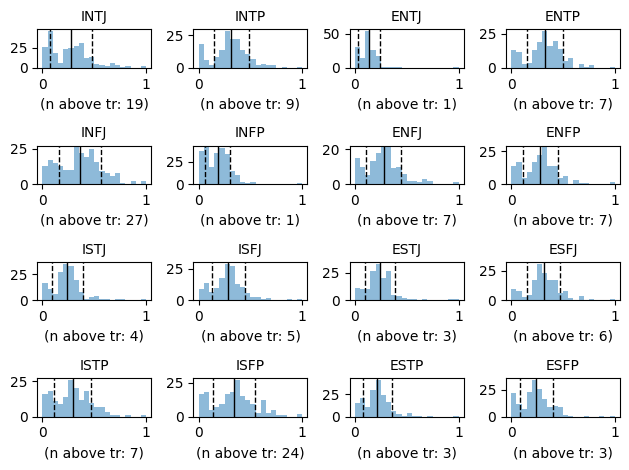

In [15]:
def plot_scores_distrib(scores: pd.Series, treshold: float = None):

    print("Average Nr. of sentences per type:\t", 
        scores.apply(len).mean())
    
    if treshold is not None:
        print("Treshold:\t", treshold)

    i = 1
    for t in scores.keys():

        t_scores = [score for (_, score) in scores[t]]

        plt.subplot(4, 4, i)
        plt.hist(
            [score for (_, score) in scores[t]],
            bins=20, 
            alpha=0.5, 
            label=t)
        # plot mean as a vertical line
        plt.axvline(np.mean(t_scores), color='k', linewidth=1)

        # plot std deviation as vertical lines
        plt.axvline(np.mean(t_scores) + np.std(t_scores), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(t_scores) - np.std(t_scores), color='k', linestyle='dashed', linewidth=1)
        plt.title(t, fontsize=10)

        # if we have a treshold, count how many sentences are above it
        if treshold is not None:
            n_above_tr = len([
                score for score in t_scores 
                if score > treshold ])
            plt.xlabel("(n above tr: " + str(n_above_tr) + ")")

        plt.tight_layout()
        i += 1

plot_scores_distrib(type_scored_sentences_tfidf, treshold=0.6)


Average Nr. of sentences per type:	 176.1875
Treshold:	 0.6


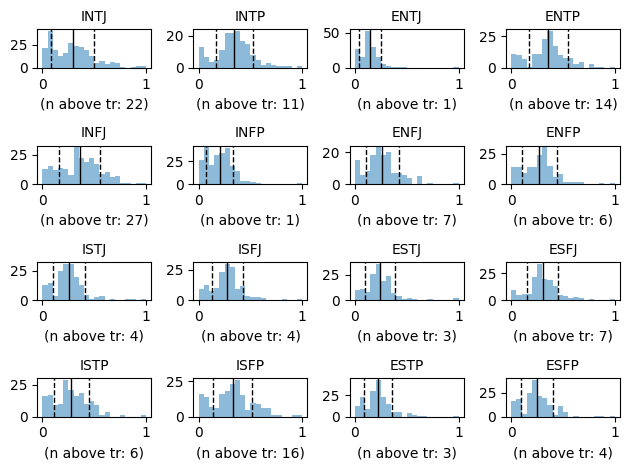

In [16]:
plot_scores_distrib(type_scored_sentences_freq, treshold=0.6)

**Observations**: 

- we can see that the distribution of scores is very different for each type
- we can see that this happens both with discriminant scores and with simple frequency scores
- (min-max normalization is not enough to uniform the distributions)

**Consequences**:
 
- to produce summaries (at least on full-texts) we cannot rely on a single treshold for all types
- we could use a classic mean + standard deviation normalization, or equivalently we can use a treshold based on some of those measures:
  - quantiles (so we obtain a sort of relative top-k sentences)
  - a treshold based on the mean + standard deviation (e.g., $mean + 1.5 * std$)

In [17]:
# apply sentence scoring also to sections
# [Needed time: 30 seconds]

sect_scored_sentences_freq = apply_sentence_scoring_to_df(
    df_types_sects, sect_freq_scores)

sect_scored_sentences_tfidf = apply_sentence_scoring_to_df(
    df_types_sects, sect_tfidf_scores)

C:\Users\Proprietario\AppData\Local\Temp\ipykernel_16824\3683853533.py:69: RuntimeWarning: invalid value encountered in scalar divide
  return [(s - min_s)/(max_s - min_s) for s in scores]


In [18]:

def calculate_treshold(sentences: List[Tuple[str, float]], alpha: float = 1) -> float:
    """Calculate a treshold for a list of scored sentences
    which depends on the mean and standard deviation of the scores. 
    
    The treshold is calculated as: mean + alpha*std_deviation"""

    scores = [score for _, score in sentences]
    return np.mean(scores) + alpha*np.std(scores)


def summarize_by_treshold(
        sentences: List[Tuple[str, float]], 
        treshold: float, 
        sep: str=" ") -> str:
    """Select only sentences with a score above a certain treshold
    and merge them in an unique summary"""

    summary = ""
    for sentence, score in sentences:
        if score > treshold:
            summary += sentence + sep

    return summary

def save_summary(summary: str, type_name: str, method: str) -> None:
    """Save a summary in a text file"""

    if not os.path.exists(f'data/summary/{method}'):
        os.makedirs(f'data/summary/{method}')

    with open(f'data/summary/{method}/{type_name}.txt', 'w') as f:
        f.write(summary)

# Apply summarization to some sample types

sample_types = types.index 
# sample_types = ['INTJ', 'ENFP', 'ISFJ']

sentences_scores = {
    "fulltext/freq": type_scored_sentences_freq, 
    "fulltext/tfidf": type_scored_sentences_tfidf, 
    }

fulltext_summaries = defaultdict(dict)

for t in sample_types:
    for method, scores in sentences_scores.items():
        tr = calculate_treshold(scores[t], alpha=1.5)
        s = summarize_by_treshold(scores[t], tr, sep="\n")
        fulltext_summaries[t][method] = s
        save_summary(s, t, method)
        

Display two summaries as examples: 

In [19]:
print("INTJ - tfidf based summary\n")
print(fulltext_summaries['INTJ']['fulltext/tfidf'])

INTJ - tfidf based summary

Architects question everything.
But ever-skeptical Architects prefer to make their own discoveries.
Architects want to be successful, not just inventive.
Architects aren’t known for being warm and fuzzy.
This personality type is full of contradictions.
Rational – Architects pride themselves on their minds.
Informed – Few personality types are as devoted as Architects to forming rational, evidence-based opinions.
Creative and self-motivated, Architects strive to do things their own way.
Determined – Architect personalities are ambitious and goal-oriented.
But this doesn’t mean that Architects are antisocial or friendless.
Architects care about depth and quality.
It’s not always easy to befriend an Architect.
Compared to other personality types, Architects aren’t especially comfortable with displays of affection.
The truth is that Architects can excel in just about any role.
And if any personality type has high standards for themselves, it’s almost certainly A

In [20]:
print("ENFP - frequency based summary\n")
print(fulltext_summaries['ENFP']['fulltext/freq'])

ENFP - frequency based summary

The Campaigner personality is a true free spirit.
These personality types may never be able to reciprocate the breadth of human interest that Campaigners present, but they do appreciate Campaigners’ efforts.
This can be a challenge for people with the Campaigner personality type – they have strong emotions, and invest those emotions heavily in the things and people they care about.
People with the Campaigner personality type possess warmth, creativity, and an open-mindedness that makes them excellent listeners.
Campaigners are growth-oriented, and as subordinates they’ll impress their managers with their creativity and adaptability.
People with the Campaigner personality type are excellent listeners, able to analyze and understand others’ perspectives effortlessly.
People with the Campaigner personality type are warm and optimistic, always searching for and usually finding win-win situations for everyone.
Few personality types are as creative and charism

### Further possible developments

- comparative summaries between two types
  - we can use tf.idf scores on only 2 types to enligthen their differences
  - we can use an unique token scores for both types (e.g., sum of frequencies of the two corpus) to enligthen their similarities

- today there exist more complex summarization tools (e.g., transformers-based, etc.)

## Clustering and grouping of MBTI types

> Can we group the MBTI types in clusters? Are there any similarities emerging from the types descriptions?

**Tools and techniques**: *clustering, PCA*

### Proposed solution and work pipeline

**Proposed solution**: use a clustering algorithm on a TF-IDF representation of the (full-text) corpus of each type and plot the results using a PCA. To endeep the difference between types, we can also use part-of-speech tagging to select only nouns, verbs and adjectives and try to cluster only them.

**Work pipeline**:

- preprocessing (as before, but without n-grams)
  - alternatively, another preprocessing based on part-of-speech tagging to extract only some parts of speech (e.g., nouns, verbs, adjectives)
- generate a TF-IDF representation of the corpus (applying appropriate filters)
- apply a clustering algorithm (e.g., K-Means)
- apply a PCA to plot the results in a 2D space


### Alternative choices and issues

**Alternative choices**:

- experiment different kinds of clustering algorithms (e.g., K-Means vs hierarchical clustering)
  - for now, we will focus just on K-Means
- experiment different kinds of filters on features (e.g., min-max document frequency)
- experiment what happens if we focus only on some parts of speech (e.g., nouns, verbs, adjectives)

**Found issues**:

In [21]:
# extract tokens from sentences and merge them in an unique text
# [Needed time: 15 seconds]

types_ft_tokens = df_types_ft["corpus"].apply(
    # we remove types letters and nicknames because they are over-represented
    lambda x: preprocessing(x, other_stopwords=types_letters_and_nicknames)
    ).apply(lambda x: " ".join(x))

In [22]:
def print_top_n_cluster_keywords(
    X, 
    kmeans: KMeans,
    types_names: List[str],
    feature_names: List[str],
    n_keywords: int = 10, ) -> None:
    """Print clusters and their top n_keywords"""

    # build a temp df with types and clusters
    df = pd.DataFrame(X.todense())
    df['Cluster'] = kmeans.labels_
    df['type'] = types_names
    df.set_index('type', inplace=True)

    # calculate the mean of each cluster
    cluster_values = df.groupby('Cluster').mean()

    # print clusters types and top n_keywords
    for i,r in cluster_values.iterrows():
        print(f"Cluster {i}:\t", df[df["Cluster"] == i].index.values)
        print(", ".join([feature_names[j] for j in np.argsort(r)[-n_keywords:]]))

def plot_clusters_pca(
    X,
    kmeans: KMeans,
    types_names: List[str], 
    random_state: int = 42) -> None:
    """Plot clusters in a 2D space using PCA"""

    # apply PCA 
    pca_vecs = PCA(n_components=2, random_state=random_state).fit_transform(X.toarray())
    x0 = pca_vecs[:,0]
    x1 = pca_vecs[:,1]

    # plot clusters in the 2D space
    df = pd.DataFrame({
        'PCA_X0': x0, 
        'PCA_X1': x1, 
        'Cluster': kmeans.labels_, 
        'type': types_names}).set_index('type')
    
    sns.scatterplot(data=df, x="PCA_X0", y="PCA_X1", hue="Cluster", palette="tab10")

    plt.title("PCA of the 16 types vectors")
    plt.xlabel("PCA X0")
    plt.ylabel("PCA X1")
    
    # add types labels to the points
    def label_point(x, y, val, ax):
        a = pd.DataFrame({'x': x, 'y': y, 'val': val})
        for i, point in a.iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))

    label_point(df["PCA_X0"], df["PCA_X1"], df.index, plt.gca())

    plt.tight_layout()



def kmeans_cluster_and_pca(
    types_tokens: pd.Series,
    n_clusters: int = 5,
    n_keywords: int = 10,
    ngram_range: Tuple[int, int]=(1,1), 
    min_df: int=1, 
    max_df: float=1.0, 
    random_state: int = 42) -> KMeans:

    """
    Apply kmeans clustering algorithm to a series of texts and use
    PCA to display the results in a 2D plot. It also prints found 
    clusters and their top n_keywords.

    Args:
        types_tokens: series of texts
        n_clusters: number of clusters you want to extract
        k_keywords: number of keywords to print from each cluster
        ngram_range: range of ngrams to consider
        min_df: minimum document frequency
        max_df: maximum document frequency
        random_state: random state for reproducibility

    Returns:
        kmeans: fitted kmeans model
    """

    # vectorize texts using tfidf and applying passed filters
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform(types_tokens)

    # apply kmeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto').fit(X)

    # print clusters and their top n_keywords
    print_top_n_cluster_keywords(
        X, kmeans, 
        types_names=types_tokens.index, 
        feature_names=vectorizer.get_feature_names_out(), 
        n_keywords=n_keywords )

    # apply PCA to reduce dimensionality to 2 and plot results
    plot_clusters_pca(X, kmeans, types_tokens.index, random_state=random_state)

    return kmeans
    
    

Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
clear, practical, tradition, done, authority, social, family, respect, responsibility, dedication
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP']
logic, freedom, natural, insight, chance, social, debate, thought, interest, intellectual
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
generally, perfect, grow, fortunately, insight, said, employee, may feel, value, might
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
action, day, experience, live, planning, relaxed, practical, fun, activity, moment


KMeans(n_clusters=4, n_init='auto', random_state=0)

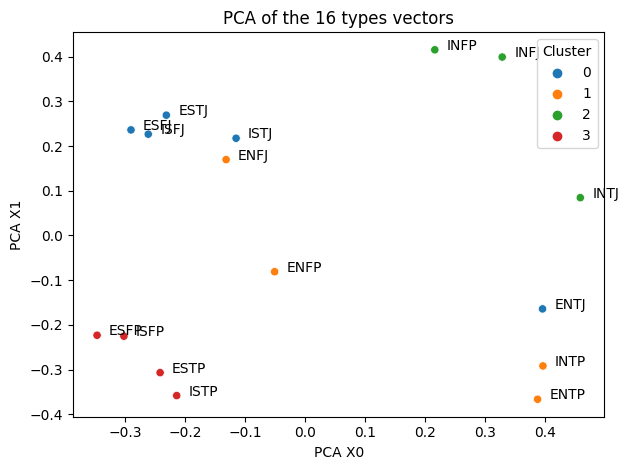

In [23]:
# Clustering Nr 01: initial setting that gives a decent result
kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2), 
    min_df=3, max_df=0.9, 
    random_state=0, 
    )

Observations: 

- the clusters seems meaningful (both according to grouping and to )
  - 0: "tradition and authority" oriented types
  - 1: "logic, intellect and debate" oriented types
  - 2: "insight and value" oriented types
  - 3: "action and experience" oriented types
- the position of the dots in the first two PCA dimensions seems related to what we found in clustering
  - $X_0$ axis seems related to "intuition" VS "sensation"
  - $X_1$ axis seems related to "perceiving" VS "judging"
- some cluster are more concentrated in PCA space than others


...but are we sure that the clustering is really meaningful?

### Experiment more min-max document frequency filters

Cluster 0:	 ['ENTJ' 'ISTJ' 'ESTJ']
relationship, others, often, work, people personality, make, personality type, type, people, personality
Cluster 1:	 ['ISFJ' 'ESFJ']
friend, take, often, social, make, need, personality type, type, people, personality
Cluster 2:	 ['INTJ' 'INTP' 'ENTP' 'INFJ' 'INFP' 'ENFJ' 'ENFP']
idea, even, find, need, people personality, may, personality type, type, people, personality
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
come, child, people personality, make, thing, need, personality type, people, type, personality


KMeans(n_clusters=4, n_init='auto', random_state=0)

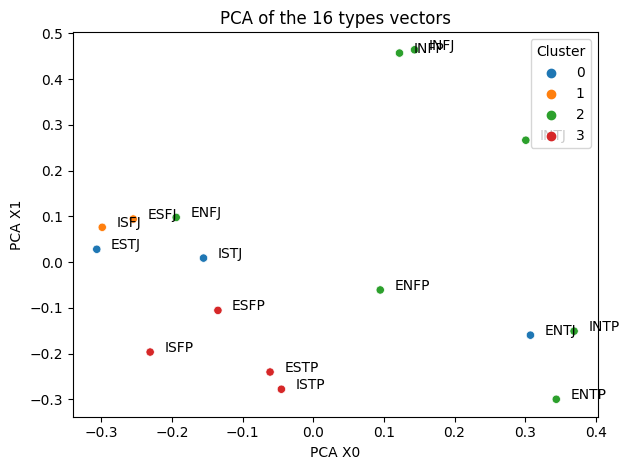

In [24]:
# Clustering Nr. 02: no frequency filters
kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2),     
    random_state=0, 
)

Observations:

- removing all frequency filters brings to different results
  - all "big intuitives" are grouped together in cluster 2
  - cluster 3 ("sensorial" types) is the same
  - the precedent cluster 0 ("tradition and authority") is now splitted in two: 0 and 1
- top 10 mean words are less discriminant than before 
  - (all clusters seems described by very generic words like "type", "personality", etc.)
- dots in PCA space are less concentrated than before

Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
standard, stable, loyalty, duty, established, tradition, authority, family, respect, dedication
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP']
bring, theory, analyst, conversation, genuine, logic, insight, chance, debate, intellectual
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
may find, inner, independence, ideal, perfect, generally, fortunately, said, insight, employee
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
joy, excitement, spontaneity, habit, charming, style, exciting, planning, relaxed, fun


KMeans(n_clusters=4, n_init='auto', random_state=0)

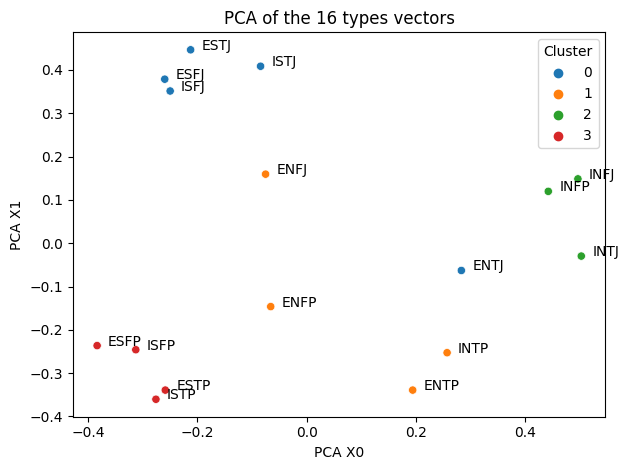

In [25]:
# Clustering Nr. 03: stricter frequency filters
kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2), 
    min_df=5, max_df=10, 
    random_state=0, 
    )

Observation: 

- with stricter filters, we obtain a similar result to the first setting
- maybe dots in PCA space are less scattered

Cluster 0:	 ['INTP' 'ENTJ' 'ENTP' 'ISTJ' 'ESTJ']
clear, point, achieve, fact, rational, respect, thought, responsibility, intellectual, debate
Cluster 1:	 ['ENFJ' 'ENFP' 'ISFJ' 'ESFJ']
value, happy, family, natural, practical, helping, team, warm, dedication, social
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
generally, perfect, grow, fortunately, insight, said, employee, may feel, value, might
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
action, day, experience, live, planning, relaxed, practical, fun, activity, moment


KMeans(n_clusters=4, n_init='auto', random_state=0)

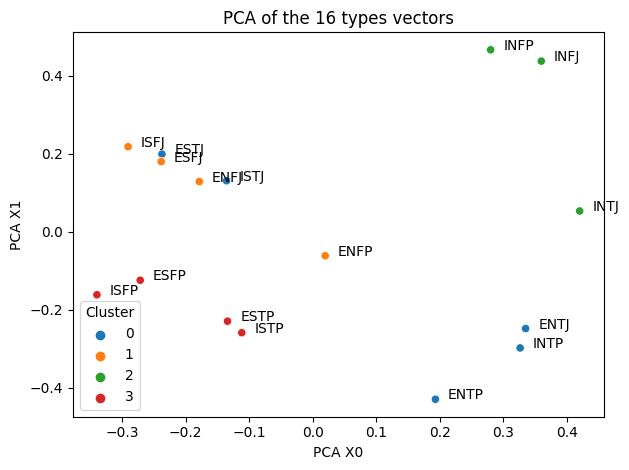

In [26]:
# Clustering Nr. 04: just a slight max frequency filter 
# to avoid very generic words
kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2), 
    max_df=0.9, 
    random_state=0, 
    )

Observations:

- clusters 2 and 3 ("insight and value", "action and experience") hold
- clusters 0 and 1 are mixed in a new way:
  - cluster 0: "rationals and responsability"
  - cluster 1: "happynes and sociality"
- PCA location of dots may suggest we can try looking for more clusters
- $X_1$ axis seems less related to "judging" VS "perceiving" dichotomy 
  - (maybe it is slightly related to "thinking" VS "feeling" (?))

Cluster 0:	 ['ISTJ' 'ESTJ']
opinion, community, tradition, clear, duty, family, dedication, responsibility, fact, respect
Cluster 1:	 ['ISFJ' 'ESFJ']
customer, responsibility, done, warm, authority, kindness, practical, family, dedication, social
Cluster 2:	 ['INFJ' 'INFP']
although, grow, belief, ideal, idealism, employee, said, may feel, value, might
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
action, day, experience, live, planning, relaxed, practical, fun, activity, moment
Cluster 4:	 ['ENFJ' 'ENFP']
team, physical, mean, excitement, natural, heart, chance, genuine, idealism, interest
Cluster 5:	 ['INTJ' 'INTP' 'ENTJ' 'ENTP']
prove, social, logic, point, achieve, debate, rational, thought, insight, intellectual


KMeans(n_clusters=6, n_init='auto', random_state=0)

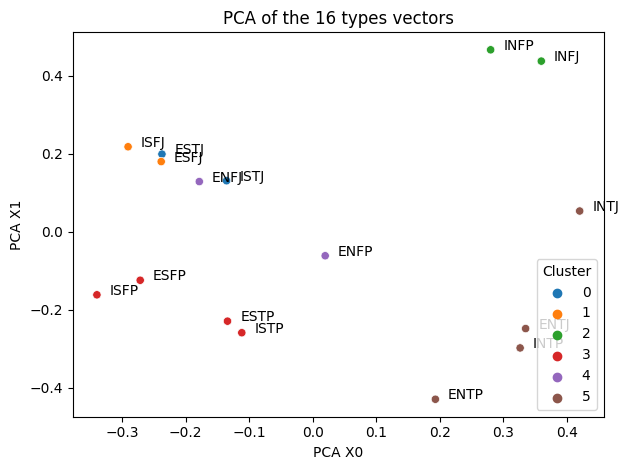

In [27]:
# Clustering Nr. 05: attempt 6 clusters
kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=6, 
    n_keywords=10, 
    ngram_range=(1,2), 
    max_df=0.9, 
    random_state=0, 
    )

Observation: 

- this last setting brings results more related to the letters of the MBTI types
- we have:
  - cluster 0: "xSTJ" ("community and tradition" oriented)
  - cluster 1: "xSFJ" ("responsibility" oriented)
  - cluster 2: "INFx" ("idealism" oriented)
  - cluster 3: "xSxP" ("action and experience" oriented)
  - cluster 4: "ENFx" ("team" oriented)
  - cluster 5: "xNTx" ("logic and thought" oriented)

Final observations: 

- it seems there isn't a single "correct" way to cluster the MBTI types
- some groupings hold more than others (e.g., "action and experience" cluster holds very well in all settings)
- some pairs of types are close than others
  - (they may move in different clusters depending on the settings, but they tend to be together)
  - e.g., `('INFP', 'INFJ'), ('ISFJ', 'ESFJ'), ('INTP', 'ENTP'), ('ISTJ', 'ESTJ')`
  - generally speaking, stable relationships seems related to the letters
- the change of some groupings suggests some types have various "facades"
  - e.g., `'ENFP'` is both a very abstract and thought-oriented and also very social
  - e.g., `'INTJ'` are interested in "logic", but also in "deep value"
  - e.g., `'ENTJ'` is attached to "hierarchy and duty", but he is also an "intuitive thinker"

- according to how types are plotted in PCA, the "intuition" vs "sensation" dichotomy seems to be relevant
  - another recurrent but less well defined dichotomy is "judging" vs "perceiving"
  - "thinking" vs "feeling" doesn't seem to emerge too much
  - "introversion" vs "extroversion" seems to be the less relevant dichotomy

### Clustering on just some parts of speech

In [28]:
def pos_extraction_preprocessing(
        text: str, 
        pos_parts: List[List[str]] = [['NOUN'], ['VERB'], ['ADJ'], ['ADV']],
        n_ngrams: int = 1, 
        lemmatizer: WordNetLemmatizer = lemmatizer, 
        other_stopwords: List[str] = [], 
        ) -> Dict[str, List[str]]:
    """
    Text preprocessing focused on extracting separately 
    some parts of speech. Output is a dictionary with
    keys corresponding to the parts of speech and values
    corresponding to the list of extracted tokens.
    """
    
    # to lower case and tokenization
    tokens = nltk.word_tokenize(text.lower())

    # pos tagging
    pos = nltk.pos_tag(tokens, tagset='universal')

    # extract parts of speech
    res = {}
    for parts in pos_parts:

        parts_name = ','.join(parts)

        # extract just a specific part of speech and
        # place it in the dictionary
        res[parts_name] = [ 
            token for (token, tag) in pos 
            if tag in parts ]
        
        # remove other stopwords
        res[parts_name] = [
            token for token in res[parts_name] \
            if token not in other_stopwords
            ]

        # lemmatization
        if lemmatizer is not None:
            res[parts_name] = [
                lemmatizer.lemmatize(token) 
                for token in res[parts_name] ]

        if n_ngrams <= 1:
            continue
    
        # n-grams generation
        generated_ngrams = res[parts_name].copy()

        for i in range(2, n_ngrams + 1):
            processed_text = ngrams(res[parts_name], i)
            generated_ngrams += [' '.join(grams) for grams in processed_text]

        res[parts_name] = generated_ngrams

    return res

In [29]:
# extract just nouns, verbs, adjectives and adverb
# [Needed time: 5s]

pos_tagged_tokens = df_types_ft["corpus"].apply(
    lambda x: pos_extraction_preprocessing(
        x, pos_parts=[
            ['NOUN'], ['VERB'], ['ADJ'], 
            ['NOUN', 'VERB'], ['NOUN', 'ADJ']], 
        n_ngrams=1,
        lemmatizer=None, # no lemmatization
        other_stopwords=types_letters_and_nicknames)
    )

nouns_tokens = pos_tagged_tokens.apply(lambda x: x['NOUN']).apply(lambda x: ' '.join(x))
verbs_tokens = pos_tagged_tokens.apply(lambda x: x['VERB']).apply(lambda x: ' '.join(x))
adjectives_tokens = pos_tagged_tokens.apply(lambda x: x['ADJ']).apply(lambda x: ' '.join(x))
nouns_verbs_tokens = pos_tagged_tokens.apply(lambda x: x['NOUN,VERB']).apply(lambda x: ' '.join(x))
nouns_adjectives_tokens = pos_tagged_tokens.apply(lambda x: x['NOUN,ADJ']).apply(lambda x: ' '.join(x))


4 clusters on nouns:
Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
qualities, roles, responsibilities, facts, family, responsibility, support, authority, respect, dedication
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP']
person, efforts, idea, freedom, idealism, qualities, problems, theories, chance, interest
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
independence, self, insight, idealism, relationship, result, lives, values, times, employees
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
spontaneity, joy, style, freedom, action, fun, focus, activities, day, moment


6 clusters on nouns:
Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
responsibility, values, care, loyalty, facts, family, authority, support, respect, dedication
Cluster 1:	 ['ENFJ' 'ENFP']
lessons, role, quality, problems, excitement, relationship, interest, chance, efforts, idealism
Cluster 2:	 ['INFJ' 'INFP']
dreams, relationship, purpose, beliefs, lives, times, result, idealism, values, employees
Cluster 3:	 ['ISFP' 'ESFP']
fun, planning,

KMeans(n_clusters=6, n_init='auto', random_state=0)

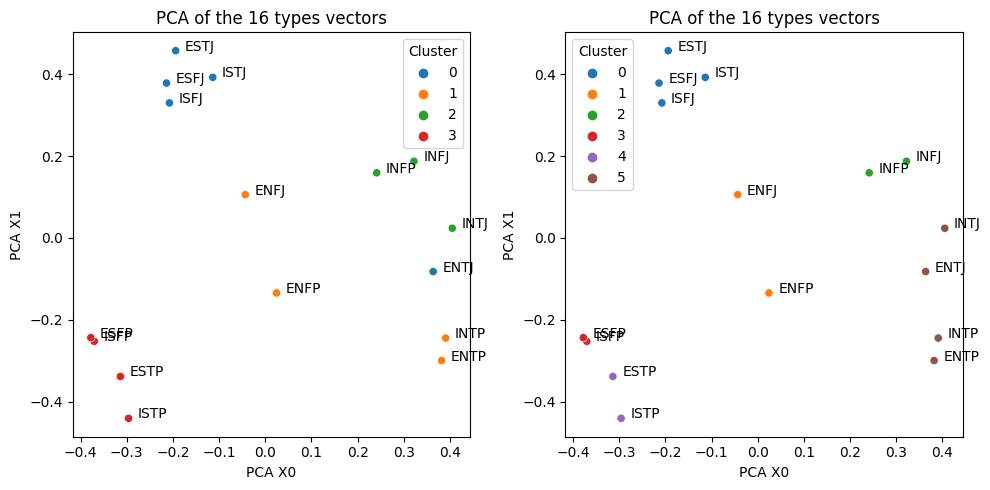

In [30]:
# Clustering just on nouns
plt.figure(figsize=(10, 5))

print("4 clusters on nouns:")
plt.subplot(1, 2, 1)
kmeans_cluster_and_pca(
    nouns_tokens,
    n_clusters=4,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9,
    random_state=0, 
    )

print("\n")

print("6 clusters on nouns:")
plt.subplot(1, 2, 2)
kmeans_cluster_and_pca(
    nouns_tokens,
    n_clusters=6,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9,
    random_state=0, 
    )


4 clusters on verbs:
Cluster 0:	 ['INTP' 'ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
managing, are need, say, must, get done, recognize, expect, achieve, ensure, established
Cluster 1:	 ['ENFJ' 'ENFP']
establish, are have, bring, giving, experience, inspire, shine, explore, helping, means
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
can find, can help, can become, care, may need, can make, may find, said, may feel, might
Cluster 3:	 ['ENTP' 'ISTP' 'ISFP' 'ESTP' 'ESFP']
need be, engage, be can, appreciated, bored, allows, know are, getting, move, live


6 clusters on verbs:
Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
finished, bring, helping, expect, ensuring, creating, are need, maintain, ensure, established
Cluster 1:	 ['ENFJ' 'ENFP']
establish, are have, bring, giving, experience, inspire, shine, explore, helping, means
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
can find, can help, can become, care, may need, can make, may find, said, may feel, might
Cluster 3:	 ['ISFP' 'ESFP']
are take, plan, does, are need, e

KMeans(n_clusters=6, n_init='auto', random_state=0)

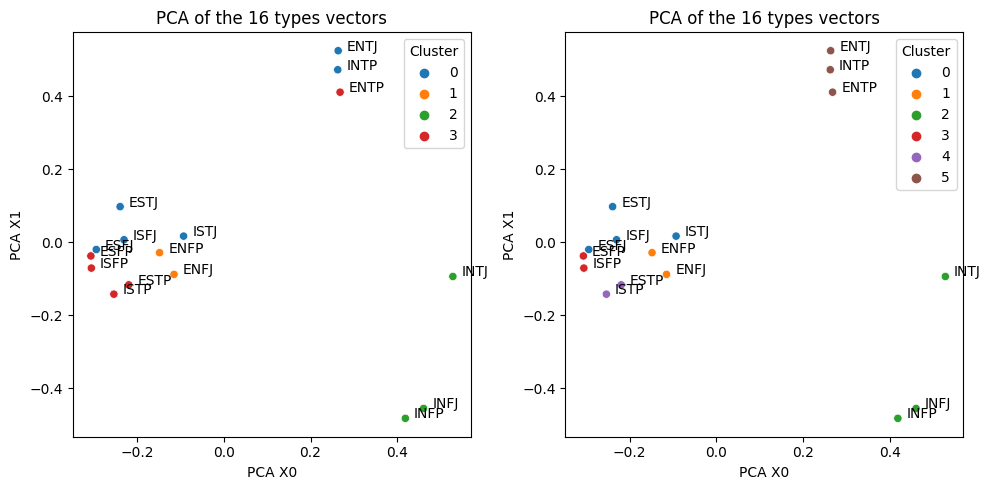

In [31]:
# Clustering just on verbs

plt.figure(figsize=(10, 5))

print("4 clusters on verbs:")
plt.subplot(1, 2, 1)
kmeans_cluster_and_pca(
    verbs_tokens,
    n_clusters=4,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.8,
    random_state=0, 
    )

print("\n")

print("6 clusters on verbs:")
plt.subplot(1, 2, 2)
kmeans_cluster_and_pca(
    verbs_tokens,
    n_clusters=6,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.8, 
    random_state=0, 
    )

4 clusters on adjectives:
Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ']
high, mutual, natural, such, stubborn, rational, long, practical, stable, clear
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP' 'ESFJ']
physical, genuine, important, such, open, happy, willing, natural, intellectual, social
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
capable, social, quiet, meaningful, deep, difficult, ideal, few, re, perfect
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
social, happy, exciting, hands, hands on, on, practical, long term, term, long


6 clusters on adjectives:
Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ']
well, such, responsible, willing, mutual, long, stubborn, practical, clear, stable
Cluster 1:	 ['ENFJ' 'ENFP' 'ESFJ']
important, esteem, self esteem, physical, mutual, willing, natural, happy, genuine, social
Cluster 2:	 ['INFJ' 'INFP']
creative, difficult, inner, few, capable, re, ideal, quiet, deep, perfect
Cluster 3:	 ['ISFP' 'ESFP']
artistic, fun, exciting, practical, happy, tangible, social, long, long term, te

KMeans(n_clusters=6, n_init='auto', random_state=0)

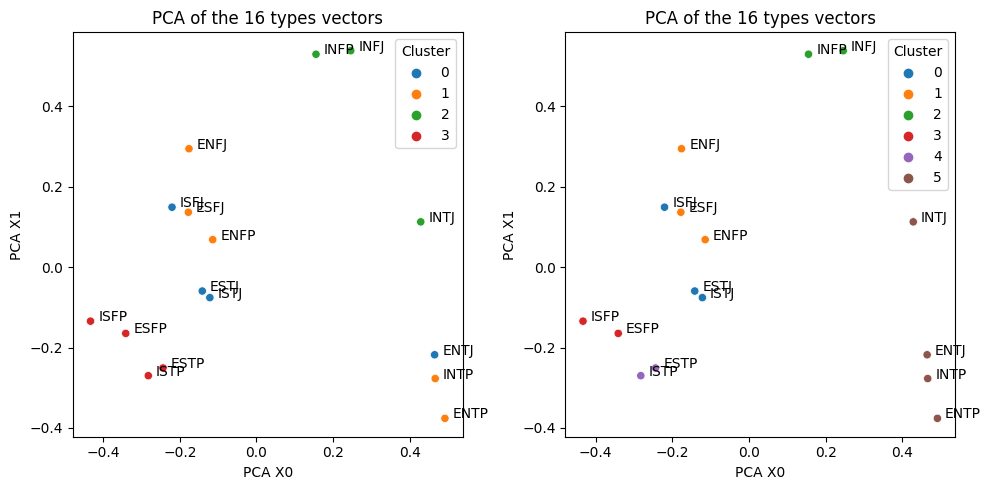

In [32]:
# Clustering just on adjectives

plt.figure(figsize=(10, 5))

print("4 clusters on adjectives:")
plt.subplot(1, 2, 1)
kmeans_cluster_and_pca(
    adjectives_tokens,
    n_clusters=4,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9, 
    random_state=0, 
    )

print("\n")

print("6 clusters on adjectives:")
plt.subplot(1, 2, 2)
kmeans_cluster_and_pca(
    adjectives_tokens,
    n_clusters=6,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9,
    random_state=0, 
    )


Final observations:

- making this POS-based clustering, we obtain similar results to what we already found
- as before, some groupings hold more than others
- while some configurations are already known (expecially the ones found using nouns), others are new.  
  - E.g., using verbs and adjectives, we finally reached to break the "action and experience" cluster in two 
    - "extroverts" vs "introverts" through verbs
    - "feelers" vs "thinkers" through adjectives

### Further possible developments

- we tried only one clustering algorithm (K-Means), what about others?
  - e.g., hierarchical clustering, DBSCAN, etc.
  - we can endeep the search of an optimal number of clusters

- we can try to rely to more complex data representations (e.g., word embeddings)


## Topic labeling on MBTI types

> Which are the main topics of each found cluster? And of each MBTI type? And of the whole dataset? 

**Tools and techniques**: *topic modeling (LDA)*

In [33]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

In [41]:
df_types_ft["corpus"].apply(
        lambda x : preprocessing(
            x, types_letters_and_nicknames))

TypeError: '<=' not supported between instances of 'list' and 'int'

In [52]:
# [Needed time: 15s]

# extract tokens 
all_tokens = df_types_ft["corpus"].apply(
    lambda x : preprocessing(
        x, other_stopwords=types_letters_and_nicknames))

# make a dictionary
all_tokens_dict = gensim.corpora.Dictionary(all_tokens)

# convert tokenized documents into a document-term matrix
lda_corpus = all_tokens.apply(lambda x: all_tokens_dict.doc2bow(x))


In [60]:
# generate LDA model
# [Needed time: 30s]

lda_model = gensim.models.LdaMulticore(
    lda_corpus, 
    num_topics=5, 
    id2word=all_tokens_dict, 
    passes=200, 
    random_state=0,)


In [61]:
for t in lda_model.print_topics(num_words=10):
    print(t)

(0, '0.005*"pleasure" + 0.004*"happily" + 0.004*"novelty" + 0.003*"planner" + 0.003*"style" + 0.003*"diversity" + 0.003*"needed" + 0.002*"aesthetic" + 0.002*"later" + 0.002*"secondary"')
(1, '0.017*"personality" + 0.013*"people" + 0.012*"type" + 0.007*"need" + 0.007*"make" + 0.007*"often" + 0.006*"work" + 0.006*"others" + 0.005*"child" + 0.005*"emotional"')
(2, '0.023*"personality" + 0.018*"people" + 0.016*"type" + 0.010*"may" + 0.009*"need" + 0.008*"make" + 0.007*"child" + 0.007*"thing" + 0.006*"way" + 0.006*"others"')
(3, '0.011*"idea" + 0.007*"debate" + 0.007*"intellectual" + 0.005*"emotional" + 0.005*"find" + 0.005*"personality" + 0.005*"new" + 0.004*"point" + 0.003*"type" + 0.003*"much"')
(4, '0.004*"discussion" + 0.003*"perceptive" + 0.003*"risk" + 0.003*"boring" + 0.003*"school" + 0.003*"observation" + 0.003*"blunt" + 0.002*"thrill" + 0.002*"sport" + 0.002*"living"')


In [62]:
for t,c in lda_corpus.items():
    print(f"{t}:\t", lda_model[c])

INTJ:	 [(2, 0.9996216)]
INTP:	 [(1, 0.9991567)]
ENTJ:	 [(1, 0.99725115)]
ENTP:	 [(1, 0.012698969), (2, 0.5000576), (3, 0.48705873)]
INFJ:	 [(2, 0.99960446)]
INFP:	 [(2, 0.9995967)]
ENFJ:	 [(2, 0.9995666)]
ENFP:	 [(2, 0.9996196)]
ISTJ:	 [(1, 0.9996118)]
ISFJ:	 [(1, 0.91732746), (2, 0.082368486)]
ESTJ:	 [(1, 0.9995632)]
ESFJ:	 [(1, 0.2965095), (2, 0.7031505)]
ISTP:	 [(1, 0.6776774), (2, 0.32200235)]
ISFP:	 [(2, 0.99955785)]
ESTP:	 [(2, 0.8024028), (4, 0.19538055)]
ESFP:	 [(0, 0.1572419), (2, 0.84242404)]
